## Install and import dependencies

Also download the dataset if not exist

In [1]:
    # !pip install -q torch_snippets pytorch_model_summary
    # !pip install -q scikit-learn

In [2]:
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from torchvision import transforms, models

from torch_snippets import *

### Define the Configs and Transforms

In [3]:
class config:
    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3 
    N_EPOCHS = 100

In [4]:
def get_transforms():
    
    return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225],
                )
    ])

## Define the dataset

In [5]:
class SegDataset(Dataset):
    
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, ix):
        
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224, 224))
        
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224, 224))
        
        return image, mask
    
    def choose(self):
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        
        ims = torch.cat([get_transforms()(im.copy()/255.)[None] for im in ims]).float().to(config.DEVICE)
        mks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(config.DEVICE)
        
        return ims, mks

## Define the  DataLoading

In [6]:
def get_dataloaders():
    
    trn_ds = SegDataset('train')
    val_ds = SegDataset('test')
    
    trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True, collate_fn=trn_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=val_ds.collate_fn)
    
    return trn_dl, val_dl

In [7]:
trn_dl, val_dl = get_dataloaders()

In [8]:
val_ds = SegDataset('test')

In [9]:
len(val_ds)

101

## Mask checking

In [10]:
import cv2

In [11]:
ex_img  = 'dataset1/images_prepped_train/0001TP_006690.png' 
ex_mask = 'dataset1/annotations_prepped_train/0001TP_006690.png'

In [12]:
### UNet Architecture

In [13]:
# Define the Convolution block
def conv(in_channels, out_channels):
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [14]:
# Define the UpConvolution block
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
    )

In [15]:
#Leverage building blocks and create the entire architecture

In [16]:
encoder = models.vgg16_bn(pretrained=True).features

C:\Users\USER\miniconda3\envs\unet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\miniconda3\envs\unet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [18]:
class UNet(nn.Module):
    
    def __init__(self, weights='VGG16_BN_Weights.DEFAULT', out_channels=12):
        
        super().__init__()
        
        self.encoder = models.vgg16_bn(weights=weights).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)
        
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        
        bottleneck = self.bottleneck(block5)
        
        x = self.conv_bottleneck(bottleneck)
        
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)
        
        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
        
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)
        
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        
        x = self.conv11(x)
        
        return x

In [19]:
model = UNet()
model

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [20]:
## Loss Function

In [21]:
CrossEnt = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    loss = CrossEnt(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

In [22]:
### Train

In [23]:
class Train():
    
    def train_batch(model, data, optimizer, criterion):
        
        model.train()
        
        imgs, masks = data
        _masks = model(imgs)
        optimizer.zero_grad()
        loss, acc = criterion(_masks, masks)
        loss.backward()
        optimizer.step()
        
        return loss.item(), acc.item()
    
    @torch.no_grad()
    def valid_batch(model, data, criterion):
        
        model.eval()

        imgs, masks = data
        _masks = model(imgs)

        loss, acc = criterion(_masks, masks)
        
        return loss.item(), acc.item()

In [24]:
### Define model, loss and optimizer

In [25]:
model = UNet().to(config.DEVICE)

criterion = UnetLoss

optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE) 

In [26]:
len(val_dl)

7

In [27]:
for epoch in range(config.N_EPOCHS):
    
    train_loss_log = []
    train_acc_log  = []
    val_loss_log   = []
    val_acc_log    = []
    
    # for bx, data in tqdm(enumerate(trn_dl)):
    for data in trn_dl:
        train_loss, train_acc = Train.train_batch(model, data, optimizer, criterion)       
        
    # for bx, data in tqdm(enumerate(val_dl)):
    for data in val_dl:
        val_loss, val_acc = Train.valid_batch(model, data, criterion)
    
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
    
    print('##########################################')
    print(f'Epoch: {epoch}, \tTrain_loss: {train_loss}, \tTrain_acc: {train_acc}, \tVal_loss: {val_loss}, \tVal_acc: {val_acc}')
    print('##########################################')

##########################################

Epoch: 0,       Train_loss: 1.336361289024353,  Train_acc: 0.756428062915802,   Val_loss: 1.5003911256790161,   
Val_acc: 0.7876315116882324

##########################################

##########################################

Epoch: 1,       Train_loss: 1.0384821891784668,         Train_acc: 0.7686782479286194,  Val_loss: 
1.017267107963562,    Val_acc: 0.7593032121658325

##########################################

##########################################

Epoch: 2,       Train_loss: 0.6983218789100647,         Train_acc: 0.879651665687561,   Val_loss: 
0.8310372233390808,   Val_acc: 0.8309350609779358

##########################################

##########################################

Epoch: 3,       Train_loss: 0.5713285207748413,         Train_acc: 0.8884779214859009,  Val_loss: 
0.7012493014335632,   Val_acc: 0.8580834865570068

##########################################

##########################################

Epoch: 4,       Train_loss: 0.5658822059631348,         Train_acc: 0.8665139079093933,  Val_loss: 
0.6818991899490356,   Val_acc: 0.8536192178726196

##########################################

##########################################

Epoch: 5,       Train_loss: 0.5298505425453186,         Train_acc: 0.8678584694862366,  Val_loss: 
0.6560169458389282,   Val_acc: 0.8564173579216003

##########################################

##########################################

Epoch: 6,       Train_loss: 0.4767620861530304,         Train_acc: 0.8889203667640686,  Val_loss: 
0.5196102857589722,   Val_acc: 0.8525190949440002

##########################################

##########################################

Epoch: 7,       Train_loss: 0.45345354080200195,        Train_acc: 0.8839564919471741,  Val_loss: 
0.6557646989822388,   Val_acc: 0.8089564442634583

##########################################

##########################################

Epoch: 8,       Train_loss: 0.5145067572593689,         Train_acc: 0.8576450943946838,  Val_loss: 
1.2459014654159546,   Val_acc: 0.6288105845451355

##########################################

##########################################

Epoch: 9,       Train_loss: 0.3485419750213623,         Train_acc: 0.9100938439369202,  Val_loss: 
0.7384018898010254,   Val_acc: 0.7661830186843872

##########################################

##########################################

Epoch: 10,      Train_loss: 0.409707635641098,  Train_acc: 0.8867227435112,     Val_loss: 0.4726389944553375,   
Val_acc: 0.8495774269104004

##########################################

##########################################

Epoch: 11,      Train_loss: 0.4252680242061615,         Train_acc: 0.8917955756187439,  Val_loss: 
0.5280178785324097,   Val_acc: 0.8356345295906067

##########################################

##########################################

Epoch: 12,      Train_loss: 0.367990642786026,  Train_acc: 0.9005354642868042,  Val_loss: 0.3982454836368561,   
Val_acc: 0.8690528869628906

##########################################

##########################################

Epoch: 13,      Train_loss: 0.35863131284713745,        Train_acc: 0.9032353162765503,  Val_loss: 
0.43563804030418396,  Val_acc: 0.8712133169174194

##########################################

##########################################

Epoch: 14,      Train_loss: 0.301930695772171,  Train_acc: 0.9202248454093933,  Val_loss: 0.46238434314727783,  
Val_acc: 0.8707987666130066

##########################################

##########################################

Epoch: 15,      Train_loss: 0.3223479986190796,         Train_acc: 0.9134314060211182,  Val_loss: 
0.42064136266708374,  Val_acc: 0.8861327767372131

##########################################

##########################################

Epoch: 16,      Train_loss: 0.281095951795578,  Train_acc: 0.9216770529747009,  Val_loss: 0.43968966603279114,  
Val_acc: 0.8630540370941162

##########################################

##########################################

Epoch: 17,      Train_loss: 0.293994277715683,  Train_acc: 0.9198793768882751,  Val_loss: 0.46302318572998047,  
Val_acc: 0.8743223547935486

##########################################

##########################################

Epoch: 18,      Train_loss: 0.28568270802497864,        Train_acc: 0.92384272813797,    Val_loss: 
0.4204420745372772,   Val_acc: 0.8864356875419617

##########################################

##########################################

Epoch: 19,      Train_loss: 0.30910012125968933,        Train_acc: 0.9149261116981506,  Val_loss: 
0.3579636216163635,   Val_acc: 0.9035992622375488

##########################################

##########################################

Epoch: 20,      Train_loss: 0.23141911625862122,        Train_acc: 0.9387117624282837,  Val_loss: 
0.388806015253067,    Val_acc: 0.8895806670188904

##########################################

##########################################

Epoch: 21,      Train_loss: 0.24210762977600098,        Train_acc: 0.9339272379875183,  Val_loss: 
0.3675127327442169,   Val_acc: 0.8941565155982971

##########################################

##########################################

Epoch: 22,      Train_loss: 0.22455434501171112,        Train_acc: 0.9380699992179871,  Val_loss: 
0.36655616760253906,  Val_acc: 0.8950533866882324

##########################################

##########################################

Epoch: 23,      Train_loss: 0.23642860352993011,        Train_acc: 0.9346274733543396,  Val_loss: 
0.3558956980705261,   Val_acc: 0.9060865640640259

##########################################

##########################################

Epoch: 24,      Train_loss: 0.17883053421974182,        Train_acc: 0.9533774852752686,  Val_loss: 
0.328957200050354,    Val_acc: 0.9100645184516907

##########################################

##########################################

Epoch: 25,      Train_loss: 0.2615818679332733,         Train_acc: 0.9277915358543396,  Val_loss: 
0.39059075713157654,  Val_acc: 0.8942601680755615

##########################################

##########################################

Epoch: 26,      Train_loss: 0.20316793024539948,        Train_acc: 0.943938672542572,   Val_loss: 
0.3640836477279663,   Val_acc: 0.9016740918159485

##########################################

##########################################

Epoch: 27,      Train_loss: 0.2149619609117508,         Train_acc: 0.9411392211914062,  Val_loss: 
0.4897245764732361,   Val_acc: 0.8809669613838196

##########################################

##########################################

Epoch: 28,      Train_loss: 0.17767460644245148,        Train_acc: 0.9525005221366882,  Val_loss: 
0.3678983747959137,   Val_acc: 0.9033442139625549

##########################################

##########################################

Epoch: 29,      Train_loss: 0.20830003917217255,        Train_acc: 0.9421582818031311,  Val_loss: 
0.3680678904056549,   Val_acc: 0.9069594740867615

##########################################

##########################################

Epoch: 30,      Train_loss: 0.22450746595859528,        Train_acc: 0.9370735287666321,  Val_loss: 
0.4060441851615906,   Val_acc: 0.894144594669342

##########################################

##########################################

Epoch: 31,      Train_loss: 0.19984282553195953,        Train_acc: 0.9441472887992859,  Val_loss: 
0.399971067905426,    Val_acc: 0.8975206613540649

##########################################

##########################################

Epoch: 32,      Train_loss: 0.17493991553783417,        Train_acc: 0.9517485499382019,  Val_loss: 
0.34480422735214233,  Val_acc: 0.9077407121658325

##########################################

##########################################

Epoch: 33,      Train_loss: 0.16331051290035248,        Train_acc: 0.9538066387176514,  Val_loss: 
0.425821989774704,    Val_acc: 0.889473021030426

##########################################

##########################################

Epoch: 34,      Train_loss: 0.16761182248592377,        Train_acc: 0.9534531831741333,  Val_loss: 
0.3370914161205292,   Val_acc: 0.9169762134552002

##########################################

##########################################

Epoch: 35,      Train_loss: 0.17436037957668304,        Train_acc: 0.9506297707557678,  Val_loss: 
0.3869045674800873,   Val_acc: 0.9029814600944519

##########################################

##########################################

Epoch: 36,      Train_loss: 0.16846145689487457,        Train_acc: 0.9534757733345032,  Val_loss: 
0.40454021096229553,  Val_acc: 0.8985171914100647

##########################################

##########################################

Epoch: 37,      Train_loss: 0.1830284297466278,         Train_acc: 0.9475234150886536,  Val_loss: 
0.37748026847839355,  Val_acc: 0.9036790132522583

##########################################

##########################################

Epoch: 38,      Train_loss: 0.16653889417648315,        Train_acc: 0.951942503452301,   Val_loss: 
0.38037851452827454,  Val_acc: 0.9055484533309937

##########################################

##########################################

Epoch: 39,      Train_loss: 0.1634228378534317,         Train_acc: 0.9534757733345032,  Val_loss: 
0.4063900411128998,   Val_acc: 0.8993144035339355

##########################################

##########################################

Epoch: 40,      Train_loss: 0.16199436783790588,        Train_acc: 0.9543938636779785,  Val_loss: 
0.40736526250839233,  Val_acc: 0.8980268836021423

##########################################

##########################################

Epoch: 41,      Train_loss: 0.15561489760875702,        Train_acc: 0.9549279808998108,  Val_loss: 
0.45590344071388245,  Val_acc: 0.8862882256507874

##########################################

##########################################

Epoch: 42,      Train_loss: 0.18614228069782257,        Train_acc: 0.9465149641036987,  Val_loss: 
0.4336792230606079,   Val_acc: 0.8984653353691101

##########################################

##########################################

Epoch: 43,      Train_loss: 0.15638676285743713,        Train_acc: 0.9543845653533936,  Val_loss: 
0.446674644947052,    Val_acc: 0.8947942852973938

##########################################

##########################################

Epoch: 44,      Train_loss: 0.16795411705970764,        Train_acc: 0.9521923065185547,  Val_loss: 
0.42468729615211487,  Val_acc: 0.8955875039100647

##########################################

##########################################

Epoch: 45,      Train_loss: 0.15564951300621033,        Train_acc: 0.954865574836731,   Val_loss: 
0.40103697776794434,  Val_acc: 0.9040576815605164

##########################################

##########################################

Epoch: 46,      Train_loss: 0.15651319921016693,        Train_acc: 0.9545533061027527,  Val_loss: 
0.4311835467815399,   Val_acc: 0.9027223587036133

##########################################

##########################################

Epoch: 47,      Train_loss: 0.15695014595985413,        Train_acc: 0.953693687915802,   Val_loss: 
0.5010590553283691,   Val_acc: 0.8859773278236389

##########################################

##########################################

Epoch: 48,      Train_loss: 0.19256962835788727,        Train_acc: 0.9442774653434753,  Val_loss: 
0.471329927444458,    Val_acc: 0.8942721486091614

##########################################

##########################################

Epoch: 49,      Train_loss: 0.16915497183799744,        Train_acc: 0.9513167142868042,  Val_loss: 
0.39911383390426636,  Val_acc: 0.9040815830230713

##########################################

##########################################

Epoch: 50,      Train_loss: 0.15429365634918213,        Train_acc: 0.9540577530860901,  Val_loss: 
0.4452463388442993,   Val_acc: 0.9013910889625549

##########################################

##########################################

Epoch: 51,      Train_loss: 0.134648859500885,  Train_acc: 0.9606159925460815,  Val_loss: 0.44392314553260803,  
Val_acc: 0.8995256423950195

##########################################

##########################################

Epoch: 52,      Train_loss: 0.10381918400526047,        Train_acc: 0.9695737957954407,  Val_loss: 
0.4918477237224579,   Val_acc: 0.8927693963050842

##########################################

##########################################

Epoch: 53,      Train_loss: 0.15093404054641724,        Train_acc: 0.9554886817932129,  Val_loss: 
0.45620253682136536,  Val_acc: 0.900641679763794

##########################################

##########################################

Epoch: 54,      Train_loss: 0.15273146331310272,        Train_acc: 0.9541773200035095,  Val_loss: 
0.44223886728286743,  Val_acc: 0.9002072215080261

##########################################

##########################################

Epoch: 55,      Train_loss: 0.14309267699718475,        Train_acc: 0.9583147168159485,  Val_loss: 
0.4710736572742462,   Val_acc: 0.8972616195678711

##########################################

##########################################

Epoch: 56,      Train_loss: 0.12591557204723358,        Train_acc: 0.9628109335899353,  Val_loss: 
0.42682382464408875,  Val_acc: 0.9040138125419617

##########################################

##########################################

Epoch: 57,      Train_loss: 0.1451842486858368,         Train_acc: 0.9562619924545288,  Val_loss: 
0.44815415143966675,  Val_acc: 0.9063535928726196

##########################################

##########################################

Epoch: 58,      Train_loss: 0.1410088837146759,         Train_acc: 0.9582589268684387,  Val_loss: 
0.43330082297325134,  Val_acc: 0.9022879004478455

##########################################

##########################################

Epoch: 59,      Train_loss: 0.12723389267921448,        Train_acc: 0.9618569612503052,  Val_loss: 
0.5093659162521362,   Val_acc: 0.8945431709289551

##########################################

##########################################

Epoch: 60,      Train_loss: 0.13591788709163666,        Train_acc: 0.9584795236587524,  Val_loss: 
0.4511876106262207,   Val_acc: 0.8993741869926453

##########################################

##########################################

Epoch: 61,      Train_loss: 0.1225382462143898,         Train_acc: 0.962325930595398,   Val_loss: 
0.4561978876590729,   Val_acc: 0.9033880233764648

##########################################

##########################################

Epoch: 62,      Train_loss: 0.12239286303520203,        Train_acc: 0.9630155563354492,  Val_loss: 
0.4751054048538208,   Val_acc: 0.897863507270813

##########################################

##########################################

Epoch: 63,      Train_loss: 0.1400490701198578,         Train_acc: 0.9585153460502625,  Val_loss: 
0.5121405124664307,   Val_acc: 0.8923788070678711

##########################################

##########################################

Epoch: 64,      Train_loss: 0.11236461997032166,        Train_acc: 0.966006338596344,   Val_loss: 
0.4795268177986145,   Val_acc: 0.8996372222900391

##########################################

##########################################

Epoch: 65,      Train_loss: 0.12256728112697601,        Train_acc: 0.962683379650116,   Val_loss: 
0.5003616213798523,   Val_acc: 0.898453414440155

##########################################

##########################################

Epoch: 66,      Train_loss: 0.14981454610824585,        Train_acc: 0.9532711505889893,  Val_loss: 
0.5234467387199402,   Val_acc: 0.891832709312439

##########################################

##########################################

Epoch: 67,      Train_loss: 0.12474144995212555,        Train_acc: 0.9616682529449463,  Val_loss: 
0.46204498410224915,  Val_acc: 0.9033003449440002

##########################################

##########################################

Epoch: 68,      Train_loss: 0.11610357463359833,        Train_acc: 0.9639814496040344,  Val_loss: 
0.45522576570510864,  Val_acc: 0.906859815120697

##########################################

##########################################

Epoch: 69,      Train_loss: 0.1254209280014038,         Train_acc: 0.9612178802490234,  Val_loss: 
0.5067684650421143,   Val_acc: 0.8943319320678711

##########################################

##########################################

Epoch: 70,      Train_loss: 0.11878853291273117,        Train_acc: 0.9636080861091614,  Val_loss: 
0.4902869760990143,   Val_acc: 0.8982540965080261

##########################################

##########################################

Epoch: 71,      Train_loss: 0.13052771985530853,        Train_acc: 0.9600698947906494,  Val_loss: 
0.4714777171611786,   Val_acc: 0.9005540013313293

##########################################

##########################################

Epoch: 72,      Train_loss: 0.12333542108535767,        Train_acc: 0.9623034000396729,  Val_loss: 
0.46653100848197937,  Val_acc: 0.9006975293159485

##########################################

##########################################

Epoch: 73,      Train_loss: 0.10699480772018433,        Train_acc: 0.966962993144989,   Val_loss: 
0.49665510654449463,  Val_acc: 0.90140300989151

##########################################

##########################################

Epoch: 74,      Train_loss: 0.11288618296384811,        Train_acc: 0.9647733569145203,  Val_loss: 
0.45923280715942383,  Val_acc: 0.9050063490867615

##########################################

##########################################

Epoch: 75,      Train_loss: 0.13508635759353638,        Train_acc: 0.9577566981315613,  Val_loss: 
0.5079941749572754,   Val_acc: 0.8940010666847229

##########################################

##########################################

Epoch: 76,      Train_loss: 0.09847182035446167,        Train_acc: 0.9692854881286621,  Val_loss: 
0.5067249536514282,   Val_acc: 0.8995455503463745

##########################################

##########################################

Epoch: 77,      Train_loss: 0.14491119980812073,        Train_acc: 0.9564958214759827,  Val_loss: 
0.7321929931640625,   Val_acc: 0.8583505749702454

##########################################

##########################################

Epoch: 78,      Train_loss: 0.3876752555370331,         Train_acc: 0.889639139175415,   Val_loss: 
1.6764705181121826,   Val_acc: 0.6578523516654968

##########################################

##########################################

Epoch: 79,      Train_loss: 0.36589622497558594,        Train_acc: 0.8954095244407654,  Val_loss: 
1.1380290985107422,   Val_acc: 0.6849290132522583

##########################################

##########################################

Epoch: 80,      Train_loss: 0.25938305258750916,        Train_acc: 0.9254610538482666,  Val_loss: 
0.5042876601219177,   Val_acc: 0.863703727722168

##########################################

##########################################

Epoch: 81,      Train_loss: 0.22193051874637604,        Train_acc: 0.9358205795288086,  Val_loss: 
0.40995559096336365,  Val_acc: 0.8978316187858582

##########################################

##########################################

Epoch: 82,      Train_loss: 0.205356165766716,  Train_acc: 0.9407817721366882,  Val_loss: 0.40956470370292664,  
Val_acc: 0.9001155495643616

##########################################

##########################################

Epoch: 83,      Train_loss: 0.16731670498847961,        Train_acc: 0.9517737627029419,  Val_loss: 
0.41139110922813416,  Val_acc: 0.9011757969856262

##########################################

##########################################

Epoch: 84,      Train_loss: 0.16044147312641144,        Train_acc: 0.9530771970748901,  Val_loss: 
0.43552660942077637,  Val_acc: 0.9011439085006714

##########################################

##########################################

Epoch: 85,      Train_loss: 0.15251018106937408,        Train_acc: 0.9547327160835266,  Val_loss: 
0.43615010380744934,  Val_acc: 0.9031130075454712

##########################################

##########################################

Epoch: 86,      Train_loss: 0.1495494693517685,         Train_acc: 0.9555312395095825,  Val_loss: 
0.4352568984031677,   Val_acc: 0.9035833477973938

##########################################

##########################################

Epoch: 87,      Train_loss: 0.15471391379833221,        Train_acc: 0.9530825018882751,  Val_loss: 
0.46054789423942566,  Val_acc: 0.9056799411773682

##########################################

##########################################

Epoch: 88,      Train_loss: 0.14641013741493225,        Train_acc: 0.9562925100326538,  Val_loss: 
0.5564674139022827,   Val_acc: 0.8783880472183228

##########################################

##########################################

Epoch: 89,      Train_loss: 0.12416614592075348,        Train_acc: 0.9624654650688171,  Val_loss: 
0.4680670499801636,   Val_acc: 0.9001474380493164

##########################################

##########################################

Epoch: 90,      Train_loss: 0.1407984495162964,         Train_acc: 0.9579746127128601,  Val_loss: 
0.5283110737800598,   Val_acc: 0.8911989331245422

##########################################

##########################################

Epoch: 91,      Train_loss: 0.154605895280838,  Train_acc: 0.9546263813972473,  Val_loss: 0.4854680895805359,   
Val_acc: 0.9004503488540649

##########################################

##########################################

Epoch: 92,      Train_loss: 0.14475317299365997,        Train_acc: 0.9564905166625977,  Val_loss: 
0.4734327495098114,   Val_acc: 0.9033442139625549

##########################################

##########################################

Epoch: 93,      Train_loss: 0.13639205694198608,        Train_acc: 0.9584569334983826,  Val_loss: 
0.4677068293094635,   Val_acc: 0.9032485485076904

##########################################

##########################################

Epoch: 94,      Train_loss: 0.11726678162813187,        Train_acc: 0.9648397564888,     Val_loss: 
0.4891148805618286,   Val_acc: 0.9010562300682068

##########################################

##########################################

Epoch: 95,      Train_loss: 0.1143878847360611,         Train_acc: 0.9652994871139526,  Val_loss: 
0.4963536560535431,   Val_acc: 0.8997847437858582

##########################################

##########################################

Epoch: 96,      Train_loss: 0.10098892450332642,        Train_acc: 0.9682225584983826,  Val_loss: 
0.5053182244300842,   Val_acc: 0.9018295407295227

##########################################

##########################################

Epoch: 97,      Train_loss: 0.14615899324417114,        Train_acc: 0.9547752141952515,  Val_loss: 
0.4904910922050476,   Val_acc: 0.9040815830230713

##########################################

##########################################

Epoch: 98,      Train_loss: 0.09582767635583878,        Train_acc: 0.9701597094535828,  Val_loss: 
0.509175717830658,    Val_acc: 0.9023357629776001

##########################################

##########################################

Epoch: 99,      Train_loss: 0.10926412045955658,        Train_acc: 0.9653845429420471,  Val_loss: 
0.521030604839325,    Val_acc: 0.8987244367599487

##########################################

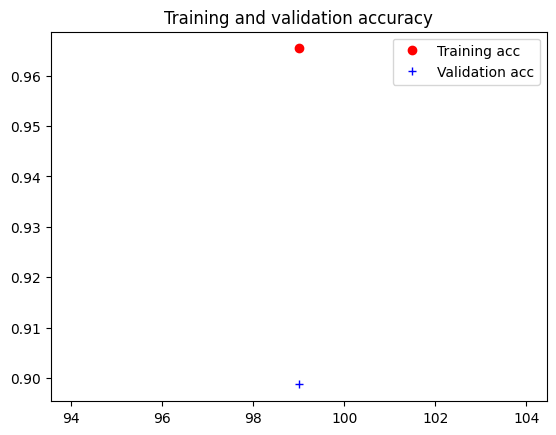

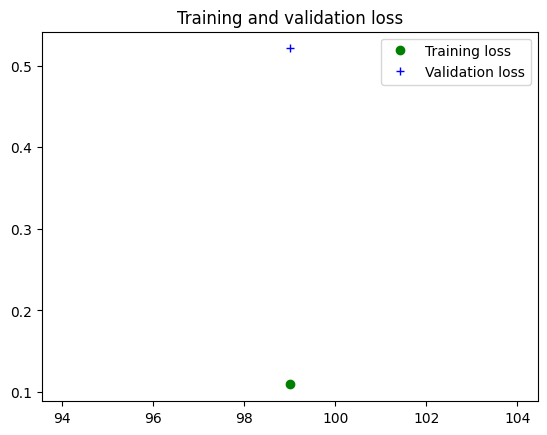

In [47]:
import matplotlib.pyplot as plt

plt.plot(epoch, train_acc, 'ro', label='Training acc')
plt.plot(epoch, val_acc, 'b+', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch, train_loss, 'go', label='Training loss')
plt.plot(epoch, val_loss, 'b+', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
for data in val_dl:
    im, mask = data
    _mask = model(im)
    _, _mask = torch.max(_mask, dim=1)

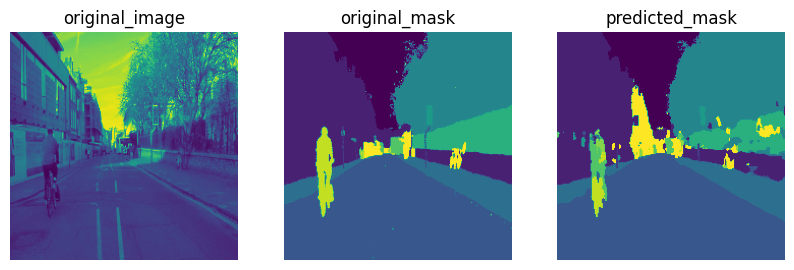

In [48]:
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 10))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0])
plt.axis('off')
plt.title("original_image")
plt.savefig("original_image.jpg") 
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])
plt.axis('off')
plt.title("original_mask")
plt.savefig("original_mask.jpg")  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0])
plt.axis('off')
plt.title("predicted_mask")
plt.savefig("predicted_mask.jpg")

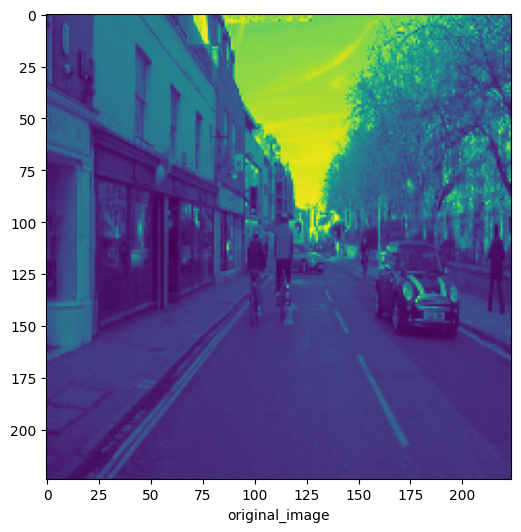

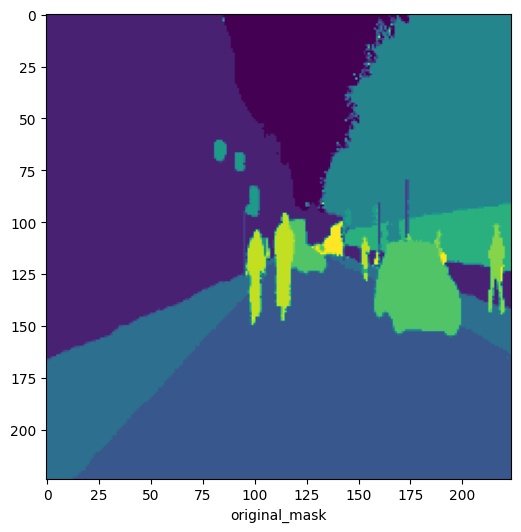

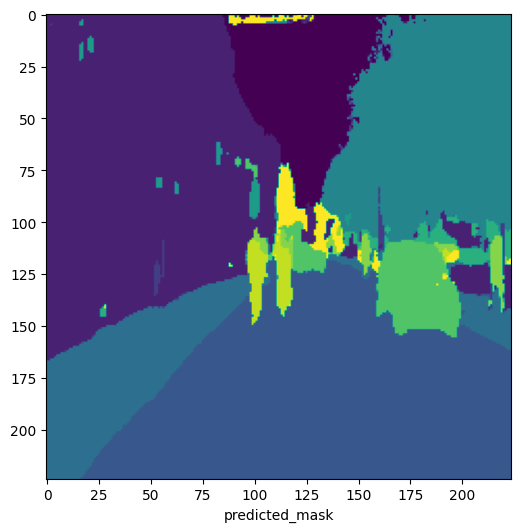

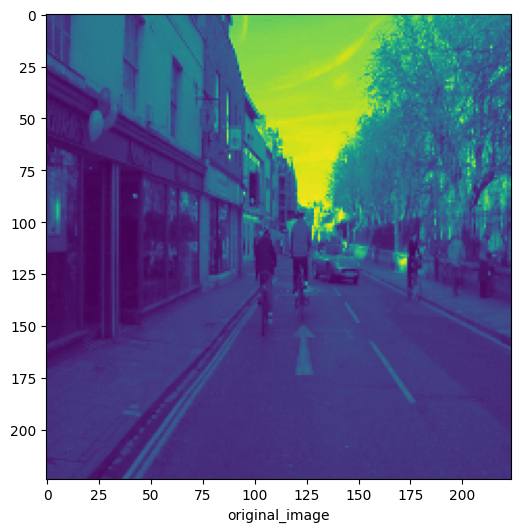

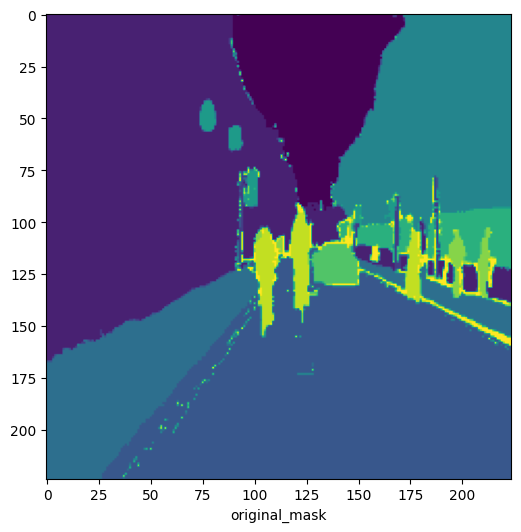

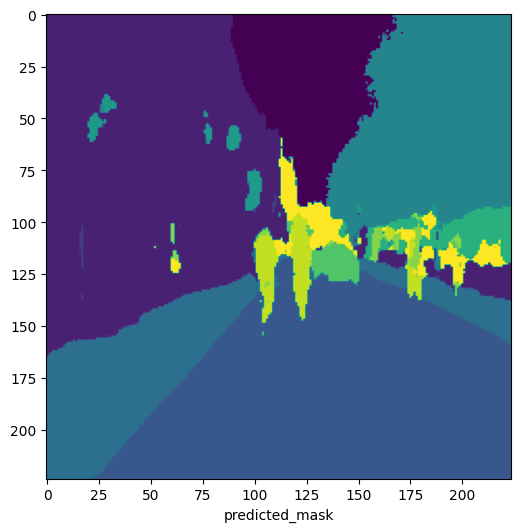

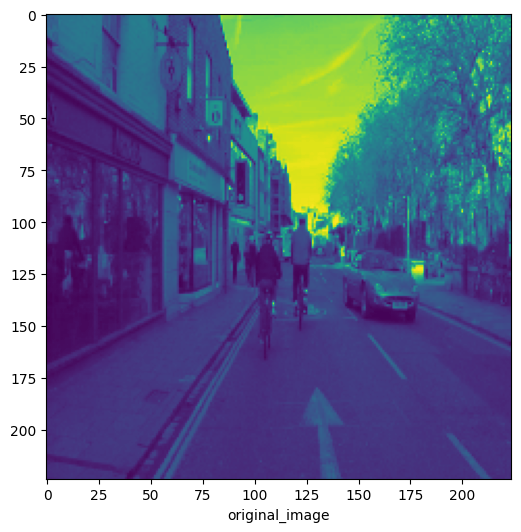

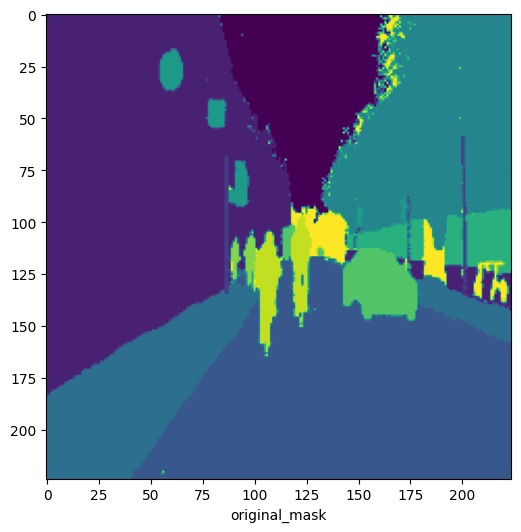

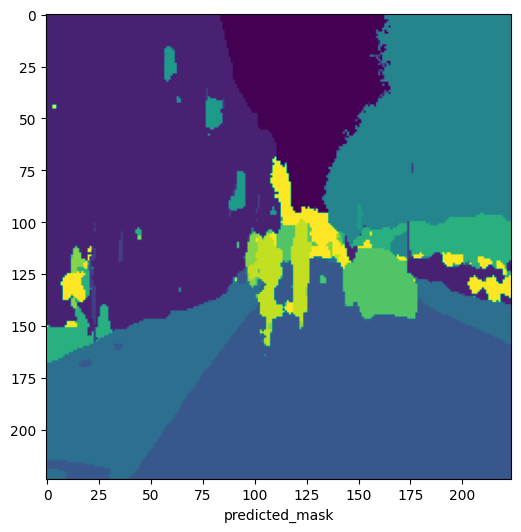

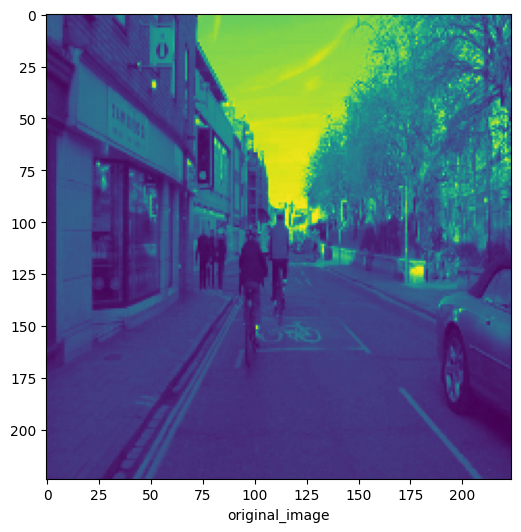

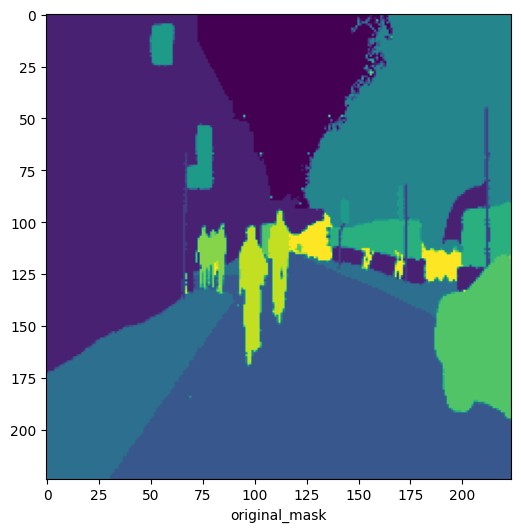

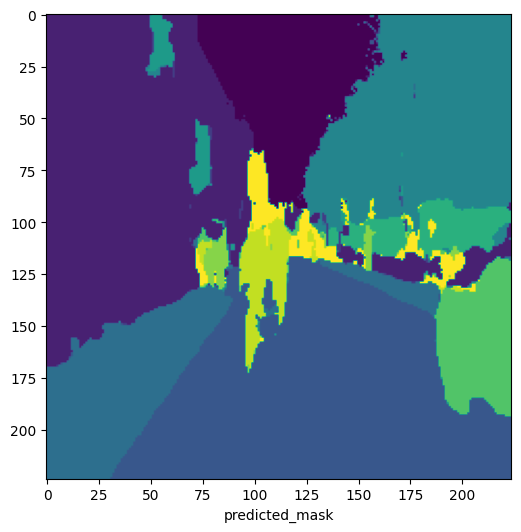

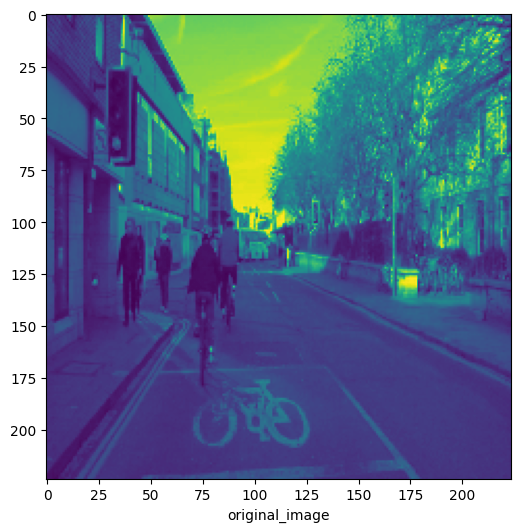

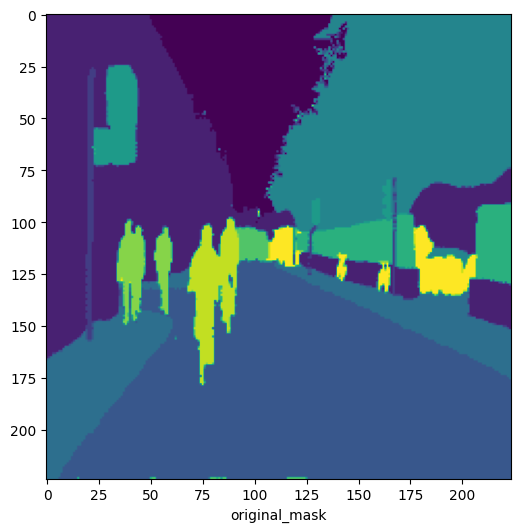

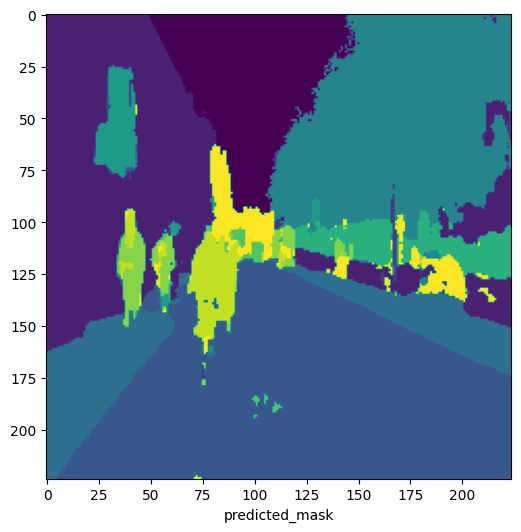

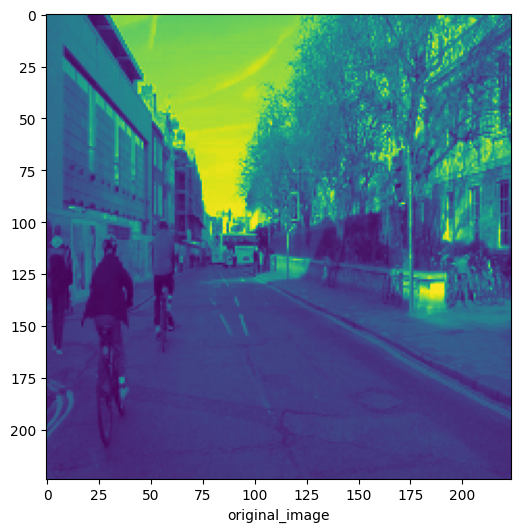

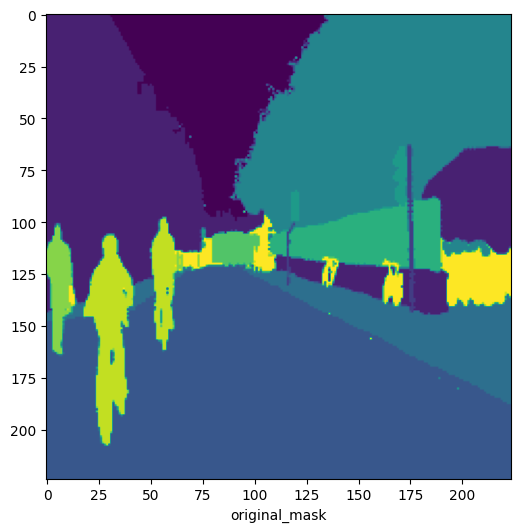

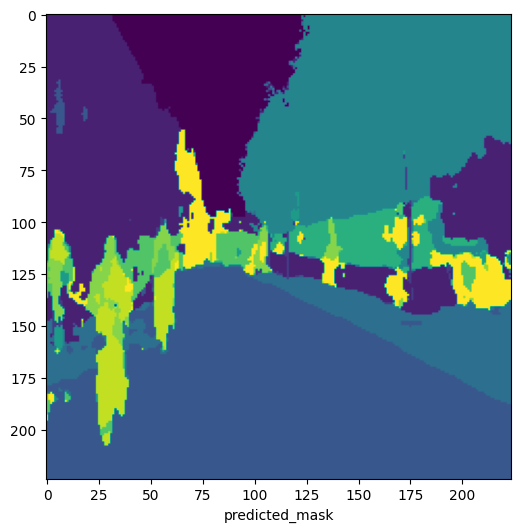

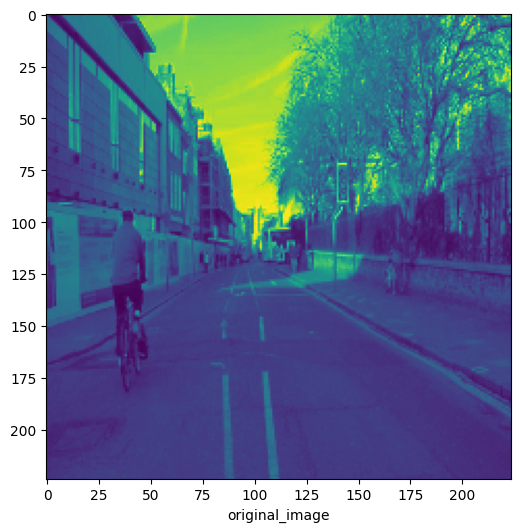

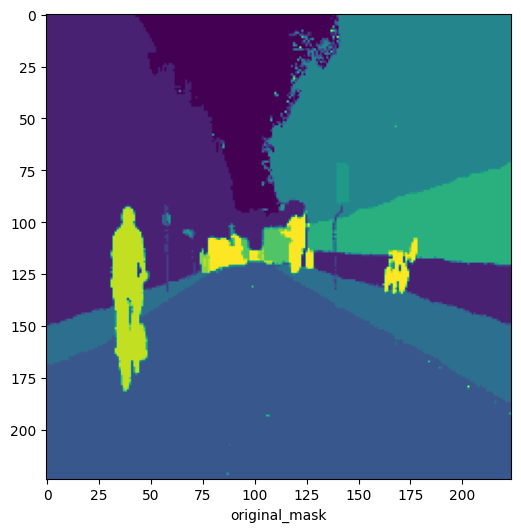

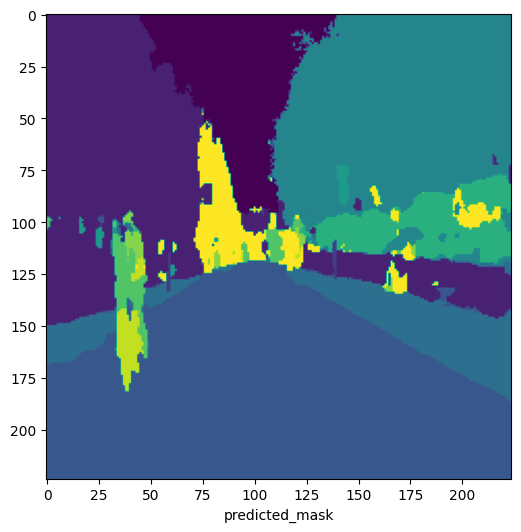

In [35]:

# for data in val_dl:
#     im, mask = data
#     _mask = model(im)
#     _, _mask = torch.max(_mask, dim=1)


#     plt.figure(figsize=(6,8))
#     #plt.axis("off")
#     plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0])
#     plt.xlabel("original_image")
#     plt.savefig("original_image.jpg")
#     plt.show()


#     plt.figure(figsize=(6,8))
#     #plt.axis("off")
#     plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])
#     plt.xlabel("original_mask")
#     plt.savefig("original_mask.jpg")
#     plt.show()


#     plt.figure(figsize=(6,8))
#     #plt.axis("off")
#     plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0])
#     plt.xlabel("predicted_mask")
#     plt.savefig("predicted_mask.jpg")
#     plt.show()
